In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
!pip install dive-into-graphs
!pip install pydig

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.loader import DataLoader

from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf

#. DGL
import dgl
import dgl.function as fn
from dgl.data import GINDataset
from dgl.nn import GNNExplainer as GNNExplainer_DGL
from dgl.dataloading import GraphDataLoader
from dgl.nn import AvgPooling
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset


#. DIG
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.method import PGExplainer
from dig.xgraph.utils.compatibility import compatible_state_dict
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import MCTS
from torch_geometric.utils import to_networkx
from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
from dig.xgraph.models import GCN_2l

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [5]:
Explainability_name = 'PGExplainer'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [6]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = SynGraphDataset('./datasets', 'BA_shapes')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [7]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))
print("-------------------------------------")


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556
-------------------------------------


In [8]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [9]:
def balanced_train_test_split(dataset):
  train_percent = 0.7
  index_list = []
  num_classes = dataset.num_classes

  for i in range(num_classes):
    index = (dataset.data.y == i).nonzero().view(-1)
    index = index[torch.randperm(index.size(0))]
    index_list.append(index)
    
  train_index = torch.cat([category_list[:int(len(category_list) * train_percent)] for category_list in index_list], dim=0)
  test_index = torch.cat([category_list[int(len(category_list) * train_percent):] for category_list in index_list], dim=0)

  train_index = train_index[torch.randperm(train_index.size(0))]
  test_index = test_index[torch.randperm(test_index.size(0))]

  dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
  dataset.data.test_mask = index_to_mask(test_index, size=dataset.data.num_nodes)
  
  dataset.data, dataset.slices = dataset.collate([dataset.data])

  return dataset

In [10]:
dataset2 = balanced_train_test_split(dataset)
dataset_PGExplainer = dataset2[0]
print(dataset_PGExplainer)
print(len(dataset_PGExplainer))
print(len(dataset_PGExplainer.x[dataset_PGExplainer.train_mask]))
print(len(dataset_PGExplainer.x[dataset_PGExplainer.test_mask]))

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
6
1891
817


In [11]:
print(type(data))

<class 'torch_geometric.data.data.Data'>


## **Training Node Features**

In [12]:
Training_Node_Features = []
first_node = []
second_node = []

for i in range(len(dataset_PGExplainer.x)):
  if dataset_PGExplainer.train_mask[i]:
    Training_Node_Features.append(dataset_PGExplainer.x[i].detach().numpy().tolist())
    

In [13]:
Training_Node_Features = torch.tensor(Training_Node_Features)
print(dataset_PGExplainer.x)
print(Training_Node_Features)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1111,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


## **Training Index List**

In [14]:
Train_Node_Names = []
for i in range(len(dataset_PGExplainer.train_mask)):
  if dataset_PGExplainer.train_mask[i]:
    Train_Node_Names.append(i)

In [15]:
print(len(Train_Node_Names))

1891


## **Training Edge Index**

In [16]:
training_edge_index_start = []
training_edge_index_end = []

for i in range(len(Train_Node_Names)):
  index = (dataset_PGExplainer.edge_index[0] == Train_Node_Names[i]).nonzero().view(-1)
  for j in index:
    origin = dataset_PGExplainer.edge_index[0][j].detach().cpu().numpy()
    origin = origin.tolist()
    training_edge_index_start.append(origin)

    destination = dataset_PGExplainer.edge_index[1][j].detach().cpu().numpy()
    destination = destination.tolist()
    training_edge_index_end.append(destination)

In [17]:
Training_Edge_Index = [] 
Training_Edge_Index.append(training_edge_index_start)
Training_Edge_Index.append(training_edge_index_end)
#first_node.append(dataset_PGExplainer.edge_index[0][i].detach().numpy().tolist())
#second_node.append(dataset_PGExplainer.edge_index[1][i].detach().numpy().tolist())

In [18]:
Training_Edge_Index = torch.tensor(Training_Edge_Index)

In [19]:
print(len(Training_Edge_Index[0]))

7299


In [20]:
print(Training_Edge_Index)
print(dataset_PGExplainer.edge_index)

tensor([[   0,    0,    0,  ..., 2703, 2704, 2705],
        [ 633, 1862, 2582,  ..., 1298,  641,  287]])
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])


## **Training Labels**

In [21]:
Training_Labels = []
for i in range(len(dataset_PGExplainer.train_mask)):
  if dataset_PGExplainer.train_mask[i]:
    target = dataset_PGExplainer.y[i].detach().cpu().numpy()
    target = target.tolist()
    Training_Labels.append(target)

In [22]:
Training_Labels = torch.tensor(Training_Labels)

In [23]:
print(len(Training_Labels))

1891


In [24]:
print(Training_Labels)
print(dataset_PGExplainer.y)

tensor([3, 4, 4,  ..., 3, 3, 3])
tensor([3, 4, 4,  ..., 3, 3, 3])


## **Create Training Dataset**

In [25]:
print(len(Training_Node_Features), len(Training_Edge_Index), len(Training_Labels))

1891 2 1891


In [26]:
print(Training_Node_Features)
print(dataset_PGExplainer.x)
print("========================================================")
print(Training_Edge_Index)
print(dataset_PGExplainer.edge_index)
print("========================================================")
print(Training_Labels)
print(dataset_PGExplainer.y[dataset_PGExplainer.train_mask])
print("========================================================")

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1111,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[   0,    0,    0,  ..., 2703, 2704, 2705],
        [ 633, 1862, 2582,  ..., 1298,  641,  287]])
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
tensor([3, 4, 4,  ..., 3, 3, 3])
tensor([3, 4, 4,  ..., 3, 3, 3])


## **Masks**

In [28]:
Trainig_Mask = torch.ones(len(Training_Node_Features), dtype=torch.bool, device=index.device)
Test_Mask = torch.zeros(len(dataset_PGExplainer.x[dataset_PGExplainer.test_mask]), dtype=torch.bool, device=index.device)

## **Create the Training Dataset**

In [29]:
from torch_geometric.data import Data

Training_Dataset = Data(x=Training_Node_Features, edge_index=Training_Edge_Index, y=Training_Labels, train_mask=Trainig_Mask)

In [30]:
print(dataset_PGExplainer)
print(data)
print(Training_Dataset)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Data(x=[1891, 1433], edge_index=[2, 7299], y=[1891], train_mask=[1891])


In [31]:
print(len(Training_Dataset.x))

1891


## **Batching Training Set**

In [32]:
Training_DataLoader = DataLoader(Training_Dataset, batch_size=64, shuffle=True)

In [35]:
print(len(Training_Dataset))
print(len(Training_DataLoader))

4
1


# **GCN MODEL**

In [227]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
      super().__init__()
      torch.manual_seed(1234567)
      self.gconv1 = GCNConv(dataset.num_features, hidden_channels)
      self.gconv2 = GCNConv(hidden_channels, dataset.num_classes)
      self.linear1 = Linear(7,7)

  def forward(self, x, edge_index, batch):
      x = self.gconv1(x, edge_index)
      x = x.relu()

      x = F.dropout(x, p=0.5, training=self.training)

      x = self.gconv2(x, edge_index)
      x = x.relu()

      x = global_mean_pool(x, batch)

      x = self.linear1(x)
      #x = x.relu()

      return x

GCN_Model_mine = GCN(hidden_channels=100)
print(GCN_Model_mine)

GCN(
  (gconv1): GCNConv(1433, 100)
  (gconv2): GCNConv(100, 7)
  (linear1): Linear(in_features=7, out_features=7, bias=True)
)


GCN_2l(
  (conv1): GCNConv(1433, 100)
  (convs): ModuleList(
    (0): GCNConv(100, 100)
  )
  (relu1): ReLU()
  (relus): ModuleList(
    (0): ReLU()
  )
  (readout): IdenticalPool()
  (ffn): Sequential(
    (0): Linear(in_features=100, out_features=7, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


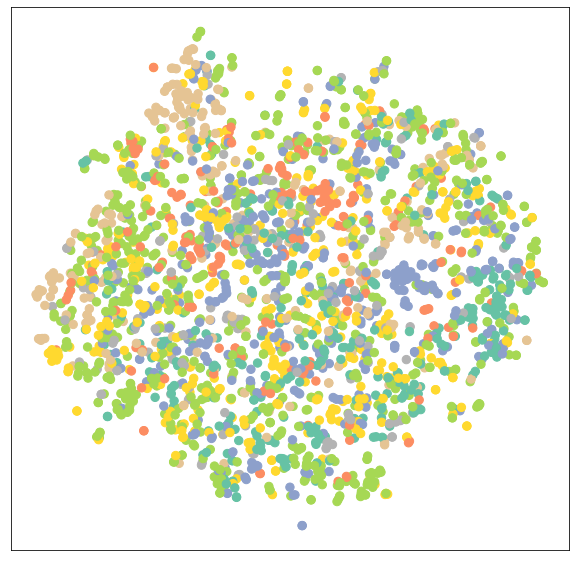

In [228]:
GCN_Model = GCN_2l(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
print(GCN_Model)
#GCN_Model = GCN(16)
GCN_Model.eval()

out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
visualize(out, color=data.y)


In [229]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.01, weight_decay=5e-4)

In [230]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [231]:
def loading_model(load_index):
  GCN_Model = GCN_2l(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
  GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.01)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [232]:
def visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [233]:
def train_step():
  GCN_Model_loss_batch = []
  GCN_Model.train(True)

  GCN_Model_Optimizer.zero_grad()
  for batch_of_graphs in Training_DataLoader:
    GCN_Model_out = GCN_Model(batch_of_graphs.x, batch_of_graphs.edge_index, batch_of_graphs.batch)  

    GCN_Model_loss = loss_calculations(GCN_Model_out, batch_of_graphs.y)
    GCN_Model_loss_batch.append(GCN_Model_loss)  
    
    GCN_Model_loss.backward(retain_graph=True)
    GCN_Model_Optimizer.step()    


  return GCN_Model_loss


In [234]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [235]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss= train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




In [236]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

KeyError: ignored

# **Test Configuration for the Model**

In [58]:
def GCN_Model_test():
  GCN_Model.eval()
  GCN_Model_out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
  GCN_Model_pred = GCN_Model_out.argmax(dim=1) 
  GCN_Model_test_correct = GCN_Model_pred[dataset_PGExplainer.test_mask] == dataset_PGExplainer.y[dataset_PGExplainer.test_mask] 
  GCN_Model_test_acc = int(GCN_Model_test_correct.sum()) / int(dataset_PGExplainer.test_mask.sum())
  return GCN_Model_test_acc

In [59]:
GCN_Model_test_acc = GCN_Model_test()
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.8825


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


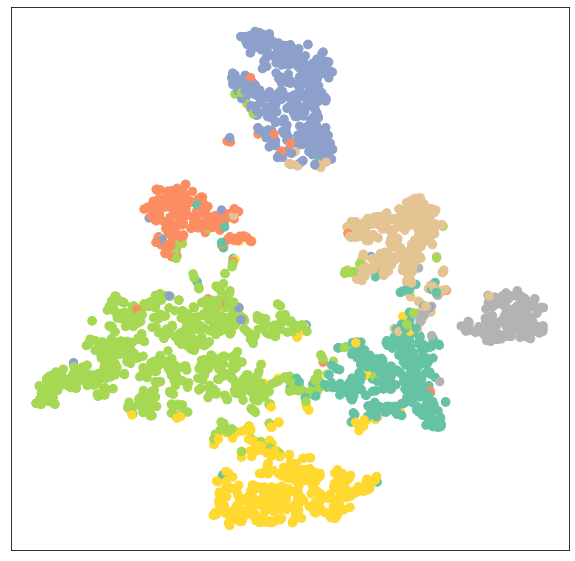

In [60]:
GCN_Model.eval()

GCN_Model_test_out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
visualize(GCN_Model_test_out, color = dataset_PGExplainer.y)

# **PGExplainer**


In [61]:
import os
import os.path as osp

import torch
from torch_geometric.data import DataLoader
from torch_geometric.data import download_url, extract_zip

from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
from dig.xgraph.utils.compatibility import compatible_state_dict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [64]:
from dig.xgraph.method import PGExplainer

PG_Explainer = PGExplainer(GCN_Model, in_channels=300, device=device, explain_graph=False, num_hops=1, epochs=1)


In [65]:

PG_Explainer.train_explanation_network(dataset2)

#torch.save(explainer.state_dict(), 'tmp.pt')
#state_dict = torch.load('tmp.pt')
#explainer.load_state_dict(state_dict)


100%|██████████| 1891/1891 [00:00<00:00, 91956.46it/s]
1891it [08:45,  3.60it/s]

Epoch: 0 | Loss: 0.37350819094992077
training time is 525.26s


In [35]:

model = explainer.state_dict()

In [36]:
print(len(model))
#print(model)

12


In [37]:
node_indices = torch.where(dataset[0].train_mask * dataset[0].y != 0)[0].tolist()

In [38]:
print(len(dataset2.data))
print(len(dataset_PGExplainer.x))
print(dataset_PGExplainer.keys)
print('whole dataset: ', len(dataset_PGExplainer.train_mask))
print('training dataset: ', len(dataset_PGExplainer.x[dataset_PGExplainer.train_mask]))
print('test dataset: ', len(dataset_PGExplainer.x[dataset_PGExplainer.test_mask]))


6
2708
['edge_index', 'x', 'test_mask', 'val_mask', 'train_mask', 'y']
whole dataset:  2708
training dataset:  1891
test dataset:  817


In [ ]:
Masks = []
for i in range(len(dataset_PGExplainer.train_mask)):
  with torch.no_grad():
    walks, masks, related_preds = explainer(dataset_PGExplainer.x, dataset_PGExplainer.edge_index, node_idx=i, y=dataset_PGExplainer.y)
    print(i)
    print(masks)

    for mask in masks:
      Masks.append(mask.detach().numpy().tolist())
    #print(Masks[0])
    #print(related_preds[0])
    #print()
#print((data.edge_index[0] == 0).nonzero())
print(len((dataset[0].edge_index[0] == 1000).nonzero()))


Streaming output truncated to the last 5000 lines.
894
[tensor([0.6992, 0.6992, 0.6936, 0.7003, 0.6936, 0.7003])]
895
[tensor([0.6781, 0.6708, 0.6708, 0.6772, 0.6699, 0.6699, 0.6781, 0.6772, 0.6762,
        0.6819, 0.6819, 0.6762, 0.6708, 0.6699, 0.6819, 0.6746, 0.6708, 0.6699,
        0.6819, 0.6746])]
896
[tensor([0.6525, 0.6525])]
897
[tensor([0.7233, 0.6880, 0.7233, 0.7204, 0.7221, 0.7222, 0.7215, 0.7233, 0.7213,
        0.7221, 0.7204, 0.7221, 0.7222, 0.7215, 0.6880, 0.7233, 0.7213, 0.7221])]
898
[tensor([0.6443, 0.6351, 0.6443, 0.6452, 0.6443, 0.6452, 0.6452, 0.6362, 0.6351,
        0.6443, 0.6452, 0.6362])]
899
[tensor([0.7421, 0.7421, 0.7403, 0.7395, 0.7474, 0.7403, 0.7395, 0.7474])]
900
[tensor([0.7412, 0.7477, 0.7412, 0.7477])]
901
[tensor([0.7050, 0.6904, 0.6904, 0.7050, 0.7032, 0.7050, 0.7032, 0.7051, 0.7050,
        0.7032, 0.6866, 0.6904, 0.7050, 0.6906, 0.7032, 0.6866, 0.7051, 0.6906,
        0.6906, 0.6904, 0.7050, 0.6906])]
902
[tensor([0.7180, 0.7180, 0.7180, 0.7180, 

In [ ]:
print(len(Masks))
print(Masks[0])
sum=0
for i in range(len(Masks)):
  sum = sum + len(Masks[i])
print(sum)
print(len(dataset_PGExplainer.edge_index[0]))
print(dataset_PGExplainer.num_edge_features)

2708
[0.715925931930542, 0.7202897667884827, 0.7202897667884827, 0.715925931930542, 0.7202897667884827, 0.7102001905441284, 0.7202897667884827, 0.7102001905441284]
30892
10556
0


In [ ]:
print(len(Masks))

2708


# **Index List of each Category**

In [ ]:
train_index_list = []
for i in range(len(dataset_PGExplainer.train_mask)):
  if dataset_PGExplainer.train_mask[i]:
    train_index_list.append(i)

test_index_list = []
for i in range(len(dataset_PGExplainer.test_mask)):
  if dataset_PGExplainer.test_mask[i]:
    test_index_list.append(i)

val_index_list = []
for i in range(len(dataset_PGExplainer.val_mask)):
  if dataset_PGExplainer.val_mask[i]:
    val_index_list.append(i)

In [ ]:
print(train_index_list)
print(len(train_index_list))

print(test_index_list)
print(len(test_index_list))

print(val_index_list)
print(len(val_index_list))

#print(len(dataset_PGExplainer.x[0]))

[1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 14, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 45, 46, 47, 49, 50, 52, 54, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 83, 84, 85, 88, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 105, 106, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 121, 123, 125, 126, 128, 132, 134, 135, 136, 137, 139, 141, 142, 145, 147, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 178, 180, 183, 184, 185, 186, 188, 190, 192, 193, 194, 195, 197, 198, 200, 201, 203, 205, 206, 208, 209, 210, 212, 213, 214, 215, 216, 217, 220, 221, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241, 242, 243, 245, 249, 250, 251, 252, 253, 254, 255, 256, 257, 260, 262, 263, 264, 265, 266, 267, 269, 270, 271, 272, 274, 275, 277, 279, 280, 283, 284, 285, 286, 287, 291, 293, 294, 295, 296, 297, 298, 299, 300,

# **Features of Each Category**

In [ ]:
training_nodes = dataset_PGExplainer.x[train_index_list]
test_nodes = dataset_PGExplainer.x[test_index_list]
val_nodes = dataset_PGExplainer.x[val_index_list]

print(len(training_nodes))
print(len(test_nodes))
print(len(val_nodes))
print(training_nodes)

training_nodes = training_nodes.detach().cpu().numpy()
training_nodes = training_nodes.tolist()

test_nodes = test_nodes.detach().cpu().numpy()
test_nodes = test_nodes.tolist()

val_nodes = val_nodes.detach().cpu().numpy()
val_nodes = val_nodes.tolist()

print(len(training_nodes))
print(len(test_nodes))
print(len(val_nodes))
#for i in range(num_classes):
#    index = (dataset.data.y == i).nonzero().view(-1)

1891
817
500
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1111,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
1891
817
500


# **Eadges of each Node**
Training

In [ ]:
edges_training_dataset = []
first_node_edge_training_dataset = []
second_node_edge_training_dataset = []
print(len(dataset_PGExplainer.edge_index[0]))

for node in train_index_list:
  index = (dataset_PGExplainer.edge_index[0] == node).nonzero().view(-1)
  A = dataset_PGExplainer.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_training_dataset.extend(A)
  
  B = dataset_PGExplainer.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_training_dataset.extend(B)

10556


In [ ]:
edges_training_dataset.append(first_node_edge_training_dataset)
edges_training_dataset.append(second_node_edge_training_dataset)

# **Eadges of each Node**
Test

In [ ]:
edges_test_dataset = []
first_node_edge_test_dataset = []
second_node_edge_test_dataset = []
print(len(dataset_PGExplainer.edge_index[0]))

for node in test_index_list:
  index = (dataset_PGExplainer.edge_index[0] == node).nonzero().view(-1)
  A = dataset_PGExplainer.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_test_dataset.extend(A)
  
  B = dataset_PGExplainer.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_test_dataset.extend(B)

10556


In [ ]:
edges_test_dataset.append(first_node_edge_test_dataset)
edges_test_dataset.append(second_node_edge_test_dataset)

# **Eadges of each Node**
Val

In [ ]:
edges_val_dataset = []
first_node_edge_val_dataset = []
second_node_edge_val_dataset = []
print(len(dataset_PGExplainer.edge_index[0]))

for node in val_index_list:
  index = (dataset_PGExplainer.edge_index[0] == node).nonzero().view(-1)
  A = dataset_PGExplainer.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_val_dataset.extend(A)
  
  B = dataset_PGExplainer.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_val_dataset.extend(B)

10556


In [ ]:
edges_val_dataset.append(first_node_edge_val_dataset)
edges_val_dataset.append(second_node_edge_val_dataset)

In [ ]:
print(dataset_PGExplainer.train_mask)
print(dataset_PGExplainer.test_mask)
print(dataset_PGExplainer.val_mask)
print()
print(edges_training_dataset[0])
print(edges_training_dataset[1])
print()
print(len(edges_training_dataset[0]), len(edges_training_dataset[1]))
print(len(edges_test_dataset[0]), len(edges_test_dataset[1]))
print(len(edges_val_dataset[0]), len(edges_val_dataset[1]))
#print(dataset_PGExplainer.edge_index)
#for i in range(len(dataset_PGExplainer.edge_index[0])):
#  print(dataset_PGExplainer.edge_index[0][i], dataset_PGExplainer.edge_index[1][i])
#  if i == 1000:
#    break

tensor([False,  True,  True,  ..., False,  True, False])
tensor([ True, False, False,  ...,  True, False,  True])
tensor([False, False, False,  ..., False, False, False])

[1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 9, 9, 11, 11, 13, 13, 14, 14, 14, 14, 14, 16, 16, 16, 16, 17, 17, 17, 17, 17, 19, 20, 20, 20, 20, 20, 22, 22, 22, 22, 22, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 41, 41, 41, 41, 43, 43, 43, 43, 43, 43, 45, 45, 45, 45, 45, 45, 46, 46, 47, 47, 49, 49, 50, 52, 52, 52, 52, 52, 54, 54, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 61, 61, 61, 61, 61, 62, 63, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 67, 67, 67, 69, 69, 69, 69, 69, 69, 69, 70, 70, 71, 71, 71, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74,

# **Labels of each Category**

In [ ]:
training_labels = dataset_PGExplainer.y[train_index_list]
test_labels = dataset_PGExplainer.y[test_index_list]
val_labels = dataset_PGExplainer.y[val_index_list]

print(len(training_labels))
print(len(test_labels))
print(len(val_labels))
print(training_labels)

training_labels = training_labels.detach().cpu().numpy()
training_labels = training_labels.tolist()

test_labels = test_labels.detach().cpu().numpy()
test_labels = test_labels.tolist()

val_labels = val_labels.detach().cpu().numpy()
val_labels = val_labels.tolist()

print(len(training_labels))
print(len(test_labels))
print(len(val_labels))

1891
817
500
tensor([4, 4, 0,  ..., 3, 3, 3])
1891
817
500


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


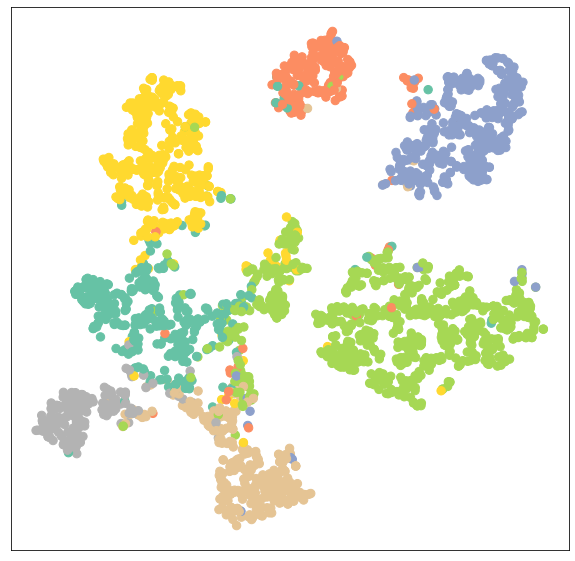

In [ ]:
out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
visualize(out, color=data.y)

In [ ]:
print(dataset_PGExplainer.keys)
print(len(dataset_PGExplainer.y[dataset_PGExplainer.train_mask]))
print(len(dataset_PGExplainer.y[dataset_PGExplainer.test_mask]))
print(len(dataset_PGExplainer.y[dataset_PGExplainer.val_mask]))
#dataset_PGExplainer.y[dataset_PGExplainer.train_mask]
print()
print(len(dataset_PGExplainer.x[dataset_PGExplainer.train_mask]))
print(len(dataset_PGExplainer.x[dataset_PGExplainer.test_mask]))
print(len(dataset_PGExplainer.x[dataset_PGExplainer.val_mask]))

print(len(dataset_PGExplainer.train_mask))
print(len(dataset_PGExplainer.test_mask))
print()
print(dataset_PGExplainer.train_mask)
print(dataset_PGExplainer.test_mask)
print(dataset_PGExplainer.val_mask)
print()
print(dataset_PGExplainer.edge_index)
print('===================================')
print(dataset_PGExplainer.x[dataset_PGExplainer.train_mask])



sum1=0
for i in dataset_PGExplainer.train_mask:
  if i:
    sum1 = sum1 + 1
print(sum1)

sum2=0
for i in dataset_PGExplainer.test_mask:
  if i:
    sum2 = sum2 + 1
print(sum2)

sum3=0
for i in dataset_PGExplainer.val_mask:
  if i:
    sum3 = sum3 + 1
print(sum3)



'''sum1=0
for i in data.train_mask:
  if i:
    sum1 = sum1 + 1
print(sum1)

sum2=0
for i in data.test_mask:
  if i:
    sum2 = sum2 + 1
print(sum2)

sum3=0
for i in data.val_mask:
  if i:
    sum3 = sum3 + 1
print(sum3)'''

['y', 'edge_index', 'val_mask', 'x', 'train_mask', 'test_mask']
1891
817
500

1891
817
500
2708
2708

tensor([False,  True,  True,  ..., False,  True, False])
tensor([ True, False, False,  ...,  True, False,  True])
tensor([False, False, False,  ..., False, False, False])

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1111,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
1891
817
500


'sum1=0\nfor i in data.train_mask:\n  if i:\n    sum1 = sum1 + 1\nprint(sum1)\n\nsum2=0\nfor i in data.test_mask:\n  if i:\n    sum2 = sum2 + 1\nprint(sum2)\n\nsum3=0\nfor i in data.val_mask:\n  if i:\n    sum3 = sum3 + 1\nprint(sum3)'